# LM算法 (Levenberg-Marquardt algorithm)

In [0]:
#@title LM算法 { display-mode: "both" }
# 本程序实现通过 Levenberg-Marquardt 算法寻找 Rosenbrock 函数的极小值点
# 可选 Rosenbrock 函数由公式 (a-x)**2+b*(y-x**2)**2 决定，代码内设置: a=1., b=1.
# 在未知最优值的情况下，初始 lam 应设置较小，LM算法接近牛顿法，收敛加速，但在最优值附近会出现震荡
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time

In [0]:
#@markdown - **计时装饰器**
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        t = end_time - start_time
        print('    Running time is: {:.4f} s.'.format(t))
        return result
    return wrapper

## 类的定义

In [0]:
#@markdown - **LM算法类**
class Strategy:
    def __init__(self, name='Levenberg-Marquardt-algorithm', opt=True, lam=5e-2, max_iters=None, tol=1e-6):
        self.name = name
        self.opt = opt
        self.lam = lam
        self.max_iters = max_iters
        self.iters = 0
        self.tol = tol

    def rosenbrock(self, x, y, a=1., b=1.): # 原函数
        return (a - x)**2 + b * (y - x**2)**2

    def rosenbrock_grad(self, x, y, a=1., b=1.): # 梯度计算式
        x_d = 2 * (x - a) - 4 * b * x * (y - x**2)
        y_d = 2 * b * (y - x**2)
        return np.array([x_d, y_d])

    #@markdown - **根据路径画出 3D 示意图**
    def draw_chart(self, path, ax, x_lim=[-2., 2], y_lim=[-2, 2], d_off=-1.5):
        x, y = np.meshgrid(np.arange(x_lim[0], x_lim[1], 0.1),
                            np.arange(y_lim[0], y_lim[1], 0.1))
        z = self.rosenbrock(x, y)
        ax.plot_surface(x, y, z, rstride=2, cstride=2, alpha=0.6, cmap=cm.jet)
        # ax.contourf(x, y, z,zdir='z', offset=d_off, cmap=cm.coolwarm) # 显示等高平面
        ax.set_xlabel('X', fontsize=14)
        ax.set_ylabel('Y', fontsize=14)
        ax.set_zlabel('Z', fontsize=14)
        # ax.set_zlim([-800.0,2500.0])
        ax.view_init(elev=27, azim=65)
        # z_labels = self.rosenbrock(np.array(path[0]), np.array(path[1]))
        z_path = self.rosenbrock(np.array(path[0]), np.array(path[1]))
        if path is not None:
            ax.plot(path[0], path[1], z_path, c="#b22222", linewidth=1.)
            # ax.plot(path[0], path[1], z_labels, c="#b22222", linewidth=1.)
            ax.scatter(path[0][0], path[1][0], z_path[0], c='r', s=30, marker='o')
            ax.scatter(path[0][-1], path[1][-1], z_path[-1], c='r', s=30, marker='*')
        ax.set_xlim(x_lim), ax.set_ylim(y_lim)
        ax.set_xticks(np.linspace(-2., 2., 5, endpoint=True))
        ax.set_yticks(np.linspace(-2., 2., 5, endpoint=True))
        ax.tick_params(labelsize=14)
    
    #@markdown - **Levenberg-Marquardt算法**
    @timer
    def LM_algor(self, init_position):
        x = [init_position[0]]
        y = [init_position[1]]
        x_real, y_real = 1., 1. # 理想情况
        while True:
            cx = x[-1]
            cy = y[-1]
            grad = self.rosenbrock_grad(cx, cy)
            Jacob_coe = np.mat(grad).T * np.mat(grad) + self.lam * np.eye(2) # 步长 delta = -(J.T * J + lam * I)^-1 * J.T * z(x,y)
            if self.opt:
                err_xy = np.array([abs(x_real - cx), abs(y_real - cy)]) # 已知最小值的坐标
                step = np.array(-Jacob_coe.I * np.mat(grad).T) * err_xy.reshape(-1, 1) # 已知最小值情况下加速收敛
            else: step = np.array(-Jacob_coe.I * np.mat(grad).T) * self.rosenbrock(cx, cy) # 实际公式，此时需将 lam 设置较小，initial_lam = 8e-8
            step = step.flatten()
            x.append(cx + step[0])
            y.append(cy + step[1])
            self.iters += 1
            # magnitude = np.sqrt(np.dot(grad, grad))
            magnitude = abs((1 - cx) * (1 - cy)) # 误差选择与真实值差的积
            if magnitude < self.tol or (self.max_iters is not None and self.iters >= self.max_iters):
                break
        return {'final_pos': [x[-1], y[-1]], 'iters': self.iters, 'final_grad': grad, 'path': [x, y]}

## 已知最优值的情况

In [0]:
# 作出 3D 路径及 x-y 平面投影图
init_position = [-1.5, -1.5] # 初始点位置
name = 'Levenberg-Marquardt-algorithm'
s = Strategy(name)
s.__dict__

{'iters': 0,
 'lam': 0.05,
 'max_iters': None,
 'name': 'Levenberg-Marquardt-algorithm',
 'opt': True,
 'tol': 1e-06}

Levenberg-marquardt-algorithm
    Running time is: 0.0021 s.
    Location of the final point: 
    x=1.0002, y=0.9975


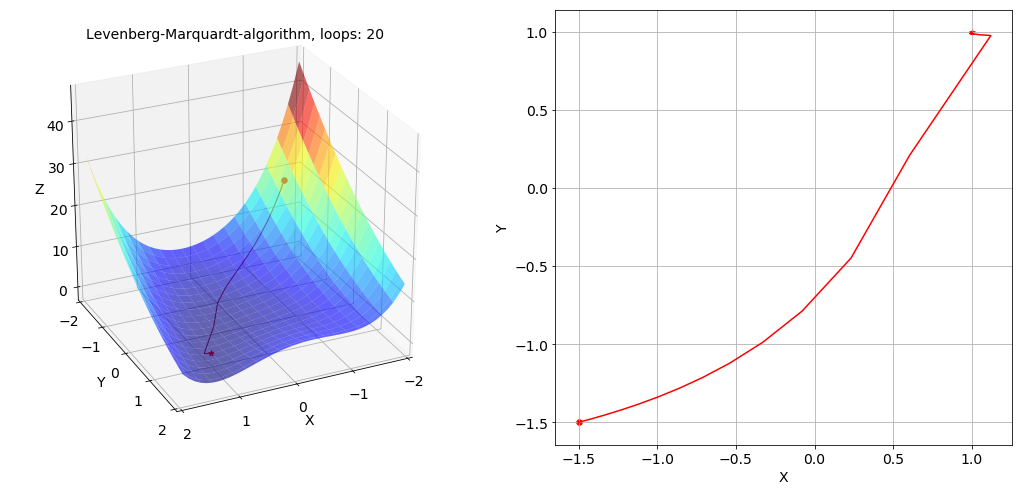

In [0]:
# 作出 3D 路径及 x-y 平面投影图
fig = plt.figure(1, figsize=(18, 8))
ax1 = fig.add_subplot(121, projection='3d')
print(name.capitalize())
result = s.LM_algor(init_position)
s.draw_chart(result['path'], ax1)
ax1.set_title('{}, loops: {:,}'.format(name, result['iters']), fontsize=14)
x_loc,y_loc = result['final_pos']
print('    Location of the final point: \n    x={:.4f}, y={:.4f}'.format(x_loc, y_loc))

ax2 = fig.add_subplot(122)
x_path,y_path = result['path']
ax2.plot(x_path, y_path,'r')
ax2.scatter(x_path[0], y_path[0], c='r', s=30, marker='o')
ax2.scatter(x_path[-1], y_path[-1], c='r', s=30, marker='*')
ax2.set_xlabel('X', fontsize=14), ax2.set_ylabel('Y', fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid(b=True)

plt.show()

## 未知最优值的情况

In [0]:
# 作出 3D 路径及 x-y 平面投影图
# 初始 lam 较小，LM算法接近牛顿法，收敛加速，但在最优值附近会出现震荡
init_position = [-1.5, -1.5] # 初始点位置
name = 'Levenberg-Marquardt-algorithm'
s = Strategy(name, opt=False, lam=8e-8)
s.__dict__

{'iters': 0,
 'lam': 8e-08,
 'max_iters': None,
 'name': 'Levenberg-Marquardt-algorithm',
 'opt': False,
 'tol': 1e-06}

Levenberg-marquardt-algorithm
    Running time is: 0.0036 s.
    Location of the final point: 
    x=0.9993, y=0.9984


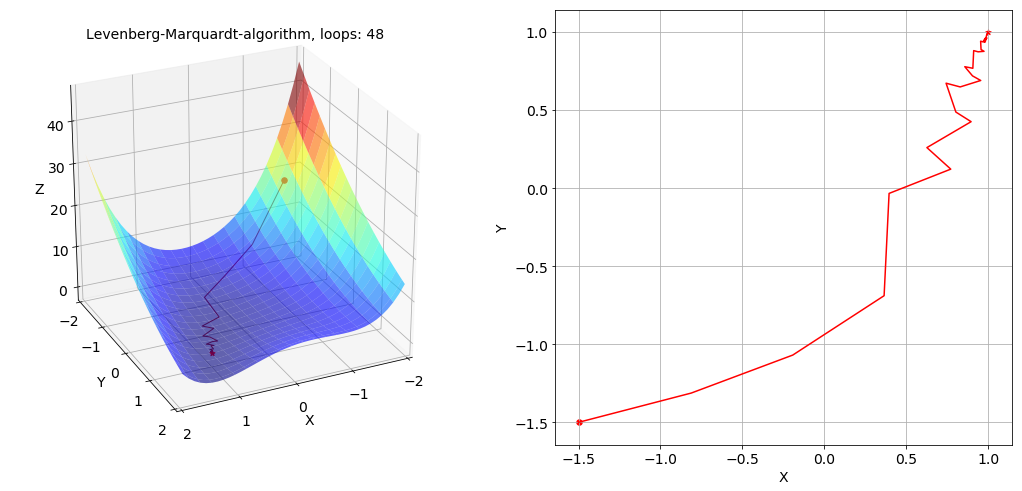

In [0]:
# 作出 3D 路径及 x-y 平面投影图
fig = plt.figure(1, figsize=(18, 8))
ax1 = fig.add_subplot(121, projection='3d')
print(name.capitalize())
result = s.LM_algor(init_position)
s.draw_chart(result['path'], ax1)
ax1.set_title('{}, loops: {:,}'.format(name, result['iters']), fontsize=14)
x_loc,y_loc = result['final_pos']
print('    Location of the final point: \n    x={:.4f}, y={:.4f}'.format(x_loc, y_loc))

ax2 = fig.add_subplot(122)
x_path,y_path = result['path']
ax2.plot(x_path, y_path,'r')
ax2.scatter(x_path[0], y_path[0], c='r', s=30, marker='o')
ax2.scatter(x_path[-1], y_path[-1], c='r', s=30, marker='*')
ax2.set_xlabel('X', fontsize=14), ax2.set_ylabel('Y', fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid(b=True)

plt.show()